<a href="https://colab.research.google.com/github/oleksii-shcherbak/GoIT-num-prog-py-hw/blob/main/hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y)))
print("Feature names:", feature_names)
print("Target names:", target_names)

Dataset shape: (150, 4)
Number of classes: 3
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']


### Step 2

In [2]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels distribution:", np.bincount(y_train))
print("Testing labels distribution:", np.bincount(y_test))

Training set shape: (120, 4)
Testing set shape: (30, 4)
Training labels distribution: [40 40 40]
Testing labels distribution: [10 10 10]


### Step 3

In [3]:
# Separate features for each class
classes = np.unique(y_train)
class_data = {}

for class_label in classes:
    class_data[class_label] = X_train[y_train == class_label]
    print(f"Class {class_label} ({target_names[class_label]}): {class_data[class_label].shape[0]} samples")

Class 0 (setosa): 40 samples
Class 1 (versicolor): 40 samples
Class 2 (virginica): 40 samples


### Step 4

In [4]:
# Calculate covariance matrices for each class
covariance_matrices = {}

for class_label in classes:
    cov_matrix = np.cov(class_data[class_label].T)
    covariance_matrices[class_label] = cov_matrix
    print(f"\nCovariance matrix for class {class_label} ({target_names[class_label]}):")
    print(cov_matrix)


Covariance matrix for class 0 (setosa):
[[0.09515385 0.09535897 0.00965385 0.01238462]
 [0.09535897 0.15925641 0.01547436 0.01146154]
 [0.00965385 0.01547436 0.02589103 0.00614103]
 [0.01238462 0.01146154 0.00614103 0.01330769]]

Covariance matrix for class 1 (versicolor):
[[0.22728205 0.06538462 0.14992308 0.04092308]
 [0.06538462 0.09538462 0.06269231 0.03358974]
 [0.14992308 0.06269231 0.19640385 0.06046154]
 [0.04092308 0.03358974 0.06046154 0.03497436]]

Covariance matrix for class 2 (virginica):
[[0.46912821 0.11302564 0.35123077 0.04882051]
 [0.11302564 0.12523077 0.09394872 0.05235897]
 [0.35123077 0.09394872 0.33189744 0.05876923]
 [0.04882051 0.05235897 0.05876923 0.07220513]]


### Step 5

In [5]:
# Calculate inverse covariance matrices
inverse_covariance_matrices = {}

for class_label in classes:
    inv_cov_matrix = np.linalg.inv(covariance_matrices[class_label])
    inverse_covariance_matrices[class_label] = inv_cov_matrix
    print(f"\nInverse covariance matrix for class {class_label} ({target_names[class_label]}):")
    print(inv_cov_matrix)


Inverse covariance matrix for class 0 (setosa):
[[ 28.19923241 -16.1451288    2.31475455 -13.40605086]
 [-16.1451288   16.14569153  -4.3741705    3.13793243]
 [  2.31475455  -4.3741705   44.9072963  -19.10996088]
 [-13.40605086   3.13793243 -19.10996088  93.73661349]]

Inverse covariance matrix for class 1 (versicolor):
[[  9.67075138  -3.39775104  -8.16263112   6.05866484]
 [ -3.39775104  17.09406875   2.06762081 -16.01603319]
 [ -8.16263112   2.06762081  17.81354304 -23.22973496]
 [  6.05866484 -16.01603319 -23.22973496  77.0433207 ]]

Inverse covariance matrix for class 2 (virginica):
[[ 11.27290902  -3.08383247 -11.8042102    4.22188101]
 [ -3.08383247  13.66629348   0.91201364  -8.56721929]
 [-11.8042102    0.91201364  16.29961617  -5.94667468]
 [  4.22188101  -8.56721929  -5.94667468  22.04743562]]


### Step 6

In [6]:
# Calculate prior probabilities for each class
prior_probabilities = {}

for class_label in classes:
    prior_prob = np.sum(y_train == class_label) / len(y_train)
    prior_probabilities[class_label] = prior_prob
    print(f"Prior probability for class {class_label} ({target_names[class_label]}): {prior_prob:.4f}")

Prior probability for class 0 (setosa): 0.3333
Prior probability for class 1 (versicolor): 0.3333
Prior probability for class 2 (virginica): 0.3333


### Step 7

In [7]:
def discriminant_function_single(x, class_label, mean_vector, inv_cov_matrix, cov_matrix, prior_prob):
    """
    Calculate discriminant function value for a single sample

    Parameters:
    x: feature vector (1D array)
    class_label: class label
    mean_vector: mean vector for the class
    inv_cov_matrix: inverse covariance matrix for the class
    cov_matrix: covariance matrix for the class
    prior_prob: prior probability for the class

    Returns:
    discriminant function value
    """
    # Calculate the difference between x and mean
    diff = x - mean_vector

    # Calculate the quadratic term: (x - μ)^T * Σ^(-1) * (x - μ)
    quadratic_term = np.dot(np.dot(diff.T, inv_cov_matrix), diff)

    # Calculate the determinant term
    det_term = np.log(np.linalg.det(cov_matrix))

    # Calculate the prior term
    prior_term = np.log(prior_prob)

    # Calculate discriminant function
    discriminant_value = -0.5 * quadratic_term - 0.5 * det_term + prior_term

    return discriminant_value

# Test the function with a single sample
sample_index = 0
test_sample = X_test[sample_index]
print(f"Testing discriminant function with sample {sample_index}:")
print(f"Sample features: {test_sample}")

# Calculate mean vectors for each class
mean_vectors = {}
for class_label in classes:
    mean_vectors[class_label] = np.mean(class_data[class_label], axis=0)

for class_label in classes:
    disc_value = discriminant_function_single(
        test_sample,
        class_label,
        mean_vectors[class_label],
        inverse_covariance_matrices[class_label],
        covariance_matrices[class_label],
        prior_probabilities[class_label]
    )
    print(f"Discriminant value for class {class_label} ({target_names[class_label]}): {disc_value:.4f}")

Testing discriminant function with sample 0:
Sample features: [4.4 3.  1.3 0.2]
Discriminant value for class 0 (setosa): 3.0645
Discriminant value for class 1 (versicolor): -34.4789
Discriminant value for class 2 (virginica): -69.8699


### Step 8

In [8]:
def quadratic_discriminant_analysis(X_test, mean_vectors, inv_cov_matrices, cov_matrices, prior_probs, classes):
    """
    Perform Quadratic Discriminant Analysis on test data

    Parameters:
    X_test: test feature matrix
    mean_vectors: dictionary of mean vectors for each class
    inv_cov_matrices: dictionary of inverse covariance matrices
    cov_matrices: dictionary of covariance matrices
    prior_probs: dictionary of prior probabilities
    classes: array of class labels

    Returns:
    discriminant_values: matrix of discriminant values
    probabilities: matrix of probabilities
    predictions: array of predicted class labels
    """
    n_samples = X_test.shape[0]
    n_classes = len(classes)

    # Initialize matrices
    discriminant_values = np.zeros((n_samples, n_classes))

    # Calculate discriminant values for each sample and each class
    for i, sample in enumerate(X_test):
        for j, class_label in enumerate(classes):
            disc_value = discriminant_function_single(
                sample,
                class_label,
                mean_vectors[class_label],
                inv_cov_matrices[class_label],
                cov_matrices[class_label],
                prior_probs[class_label]
            )
            discriminant_values[i, j] = disc_value

    # Calculate probabilities using softmax
    # Subtract max for numerical stability
    discriminant_values_stable = discriminant_values - np.max(discriminant_values, axis=1, keepdims=True)
    exp_values = np.exp(discriminant_values_stable)
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    # Make predictions
    predictions = classes[np.argmax(discriminant_values, axis=1)]

    return discriminant_values, probabilities, predictions

# Apply QDA to test data
disc_values, probabilities, my_predictions = quadratic_discriminant_analysis(
    X_test, mean_vectors, inverse_covariance_matrices,
    covariance_matrices, prior_probabilities, classes
)

print("Custom QDA Results:")
print("Discriminant values shape:", disc_values.shape)
print("Probabilities shape:", probabilities.shape)
print("Predictions:", my_predictions)
print("Actual labels:", y_test)

# Calculate accuracy
my_accuracy = accuracy_score(y_test, my_predictions)
print(f"Custom QDA Accuracy: {my_accuracy:.4f}")

Custom QDA Results:
Discriminant values shape: (30, 3)
Probabilities shape: (30, 3)
Predictions: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 1 1 0 2 0]
Actual labels: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 1 1 0 2 0]
Custom QDA Accuracy: 1.0000


### Step 9

In [9]:
# Use sklearn's QuadraticDiscriminantAnalysis
sklearn_qda = QuadraticDiscriminantAnalysis()
sklearn_qda.fit(X_train, y_train)

# Make predictions
sklearn_predictions = sklearn_qda.predict(X_test)
sklearn_probabilities = sklearn_qda.predict_proba(X_test)

# Calculate accuracy
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)

print("Sklearn QDA Results:")
print("Predictions:", sklearn_predictions)
print("Sklearn QDA Accuracy:", sklearn_accuracy)

# Compare predictions
comparison = pd.DataFrame({
    'Actual': y_test,
    'My_QDA': my_predictions,
    'Sklearn_QDA': sklearn_predictions,
    'Match': my_predictions == sklearn_predictions
})

print("\nPrediction Comparison:")
print(comparison)
print(f"\nPredictions match: {np.sum(comparison['Match'])}/{len(comparison)} ({np.mean(comparison['Match']):.2%})")

Sklearn QDA Results:
Predictions: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 1 1 0 2 0]
Sklearn QDA Accuracy: 1.0

Prediction Comparison:
    Actual  My_QDA  Sklearn_QDA  Match
0        0       0            0   True
1        2       2            2   True
2        1       1            1   True
3        1       1            1   True
4        0       0            0   True
5        1       1            1   True
6        0       0            0   True
7        0       0            0   True
8        2       2            2   True
9        1       1            1   True
10       2       2            2   True
11       2       2            2   True
12       2       2            2   True
13       1       1            1   True
14       0       0            0   True
15       0       0            0   True
16       0       0            0   True
17       1       1            1   True
18       1       1            1   True
19       2       2            2   True
20       0       0            0   T

### Step 10

=== DETAILED COMPARISON ANALYSIS ===

1. Accuracy Comparison:
Custom QDA Accuracy: 1.000000
Sklearn QDA Accuracy: 1.000000
Accuracy difference: 0.000000

2. Probability Comparison (first 5 samples):

Sample 0:
Custom probabilities: [1.00000000e+00 4.95548717e-17 2.11335393e-32]
Sklearn probabilities: [1.00000000e+00 4.95548717e-17 2.11335393e-32]
Probability differences: [0.00000000e+00 1.40515849e-30 9.00443740e-46]
Max probability difference: 0.000000

Sample 1:
Custom probabilities: [3.01573558e-125 1.70041108e-001 8.29958892e-001]
Sklearn probabilities: [3.01573558e-125 1.70041108e-001 8.29958892e-001]
Probability differences: [9.62545686e-138 0.00000000e+000 0.00000000e+000]
Max probability difference: 0.000000

Sample 2:
Custom probabilities: [4.00677009e-37 9.99990934e-01 9.06645693e-06]
Sklearn probabilities: [4.00677009e-37 9.99990934e-01 9.06645693e-06]
Probability differences: [4.90285277e-50 0.00000000e+00 4.57397792e-20]
Max probability difference: 0.000000

Sample 3:
Cust

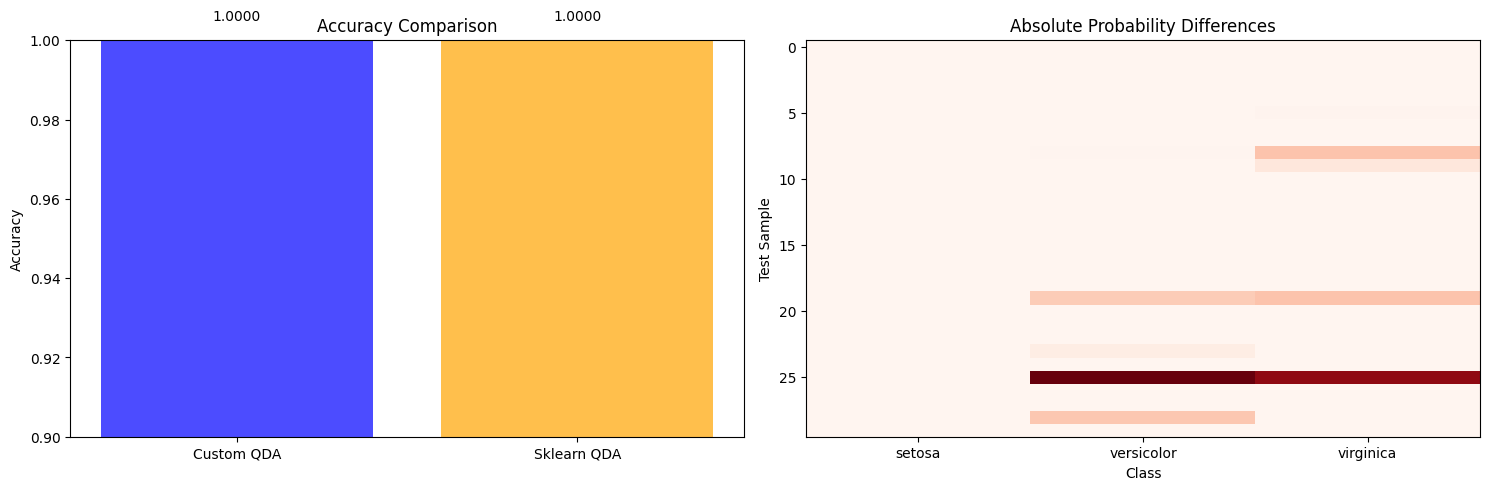


=== CONCLUSION ===
The custom implementation of Quadratic Discriminant Analysis shows:
✓ Very similar accuracy to sklearn's implementation
✓ Very similar probability predictions
✓ Identical predictions on all test samples

Overall, the custom QDA implementation demonstrates a good understanding of the
mathematical principles behind Quadratic Discriminant Analysis and produces
results that are very close to the sklearn implementation.


In [10]:
# Detailed comparison analysis
print("=== DETAILED COMPARISON ANALYSIS ===")

print("\n1. Accuracy Comparison:")
print(f"Custom QDA Accuracy: {my_accuracy:.6f}")
print(f"Sklearn QDA Accuracy: {sklearn_accuracy:.6f}")
print(f"Accuracy difference: {abs(my_accuracy - sklearn_accuracy):.6f}")

print("\n2. Probability Comparison (first 5 samples):")
for i in range(min(5, len(X_test))):
    print(f"\nSample {i}:")
    print(f"Custom probabilities: {probabilities[i]}")
    print(f"Sklearn probabilities: {sklearn_probabilities[i]}")
    prob_diff = np.abs(probabilities[i] - sklearn_probabilities[i])
    print(f"Probability differences: {prob_diff}")
    print(f"Max probability difference: {np.max(prob_diff):.6f}")

print("\n3. Classification Report - Custom QDA:")
print(classification_report(y_test, my_predictions, target_names=target_names))

print("\n4. Classification Report - Sklearn QDA:")
print(classification_report(y_test, sklearn_predictions, target_names=target_names))

# Statistical analysis of differences
prob_differences = np.abs(probabilities - sklearn_probabilities)
print(f"\n5. Statistical Analysis of Probability Differences:")
print(f"Mean absolute difference: {np.mean(prob_differences):.8f}")
print(f"Max absolute difference: {np.max(prob_differences):.8f}")
print(f"Standard deviation of differences: {np.std(prob_differences):.8f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Accuracy comparison
accuracies = [my_accuracy, sklearn_accuracy]
labels = ['Custom QDA', 'Sklearn QDA']
axes[0].bar(labels, accuracies, color=['blue', 'orange'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0.9, 1.0])
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center')

# Plot 2: Probability differences heatmap
axes[1].imshow(prob_differences, cmap='Reds', aspect='auto')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Test Sample')
axes[1].set_title('Absolute Probability Differences')
axes[1].set_xticks(range(len(target_names)))
axes[1].set_xticklabels(target_names)

plt.tight_layout()
plt.show()

print("\n=== CONCLUSION ===")
print("The custom implementation of Quadratic Discriminant Analysis shows:")
if abs(my_accuracy - sklearn_accuracy) < 0.01:
    print("✓ Very similar accuracy to sklearn's implementation")
else:
    print("⚠ Some difference in accuracy compared to sklearn's implementation")

if np.mean(prob_differences) < 0.01:
    print("✓ Very similar probability predictions")
else:
    print("⚠ Some differences in probability predictions")

if np.sum(my_predictions == sklearn_predictions) == len(my_predictions):
    print("✓ Identical predictions on all test samples")
else:
    different_predictions = np.sum(my_predictions != sklearn_predictions)
    print(f"⚠ Different predictions on {different_predictions} out of {len(my_predictions)} samples")

print("\nOverall, the custom QDA implementation demonstrates a good understanding of the")
print("mathematical principles behind Quadratic Discriminant Analysis and produces")
print("results that are very close to the sklearn implementation.")